In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from tools.cbook import pickle2Obj
import tools
from tools.FV3_tools import read_solo_fields
from tools.CM1_tools import read_cm1_fields

from pltbook import nice_clevels, nice_mxmnintvl, container, plot_contour_row

import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]

_nthreads = 2

# draw filled contours.
wclevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70]

wclevs = [0, 0.5, 2, 4, 6, 8, 10, 12, 15, 20]

tclevs = list(-40.0 + 2*np.arange(41))

pclevs = list(-15.0 + np.arange(31))

dclevs = list(-20.0 + np.arange(41))

zlevels = 25.0 + 60.*np.arange(300)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
paths = {}
paths['cm1_3km'] = '/work/wicker/climate_runs/cm1r20.3/run/plume_3km'
paths['cm1_2km'] = '/work/wicker/climate_runs/cm1r20.3/run/plume_2km'
paths['cm1_1km'] = '/work/wicker/climate_runs/cm1r20.3/run/plume_1km'

cm1 = []

for key in paths:
    print("Reading: ",key)
    try:
        cm1.append( read_cm1_fields(paths[key], vars = ['w'], zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )
    except:
        pass

Reading:  cm1_3km
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/cm1r20.3/run/plume_3km/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/climate_runs/cm1r20.3/run/plume_3km/cm1out.nc 

 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/plume_3km/cm1out.nc 

------------------------------------------------------------------------------------------------------------------------
 Interpolating fields to single column z-grid:  /work/wicker/climate_runs/cm1r20.3/run/plume_3km/cm1out.nc 

 Finished interp fields to single column z-grid:  /work/wicker/climate_runs/cm1r20.3/run/plume_3km/cm1out.nc 

------------------------------------------------------------------------------------------------------------------------
Reading:  cm1_2km


### READ SOLO FILES IN

In [5]:
paths = {}
paths['solo_3km'] = '/work/wicker/climate_runs/Solo/plume_3km'
paths['solo_2km'] = '/work/wicker/climate_runs/Solo/plume_2km'
paths['solo_1km'] = '/work/wicker/climate_runs/Solo/plume_1km'

solo = []
for key in paths:
    print("Reading: ",key)
    try:
        solo.append( read_solo_fields(paths[key], vars = ['w'],  zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )
    except:
        print("\n\n CANNOT READ FILE:  %s\n" % paths[key])
        pass
    

Reading:  solo_3km
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/Solo/plume_3km/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/climate_runs/Solo/plume_3km/atmos_hifreq.nc 

 Completed reading in:  /work/wicker/climate_runs/Solo/plume_3km/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
 Interpolating fields to single column z-grid:  /work/wicker/climate_runs/Solo/plume_3km/atmos_hifreq.nc 

 Finished interp fields to single column z-grid:  /work/wicker/climate_runs/Solo/plume_3km/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
Reading:  solo_2km
--------

(300, 60)

(300, 42)


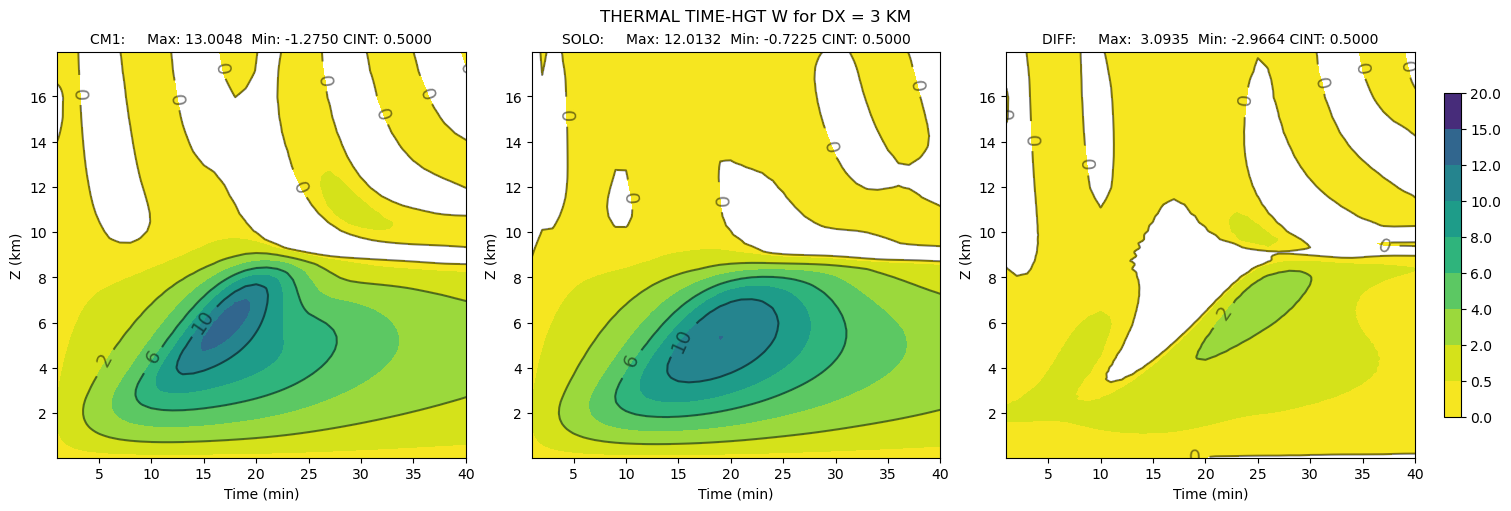

In [18]:
time1 = solo[0]['min'][:]
time2 = cm1[0]['min'][:]

fields = []

iloc, jloc = 32, 32

solo_w = solo[0]['w'] [:, :, jloc, iloc].transpose()
solo_z = solo[0]['zc'][:, :, jloc, iloc].transpose()

cm1_w = cm1[0]['w'] [:, :, jloc, iloc].transpose()
cm1_z = cm1[0]['zc'][:, :, jloc, iloc].transpose()

diff_w = solo_w[:,0:42] - cm1_w

fields.append(container(cm1_w,  time2, cm1_z/1000.))
fields.append(container(solo_w, time1, solo_z/1000.))
fields.append(container(diff_w, time2, solo_z[:,0:42]/1000.))

plot_contour_row(fields, levels=wclevs, suptitle='THERMAL TIME-HGT W for DX = 3 KM', ptitle=['CM1', 'SOLO', 'DIFF'], range=[1,40], xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r, cint=2.5);


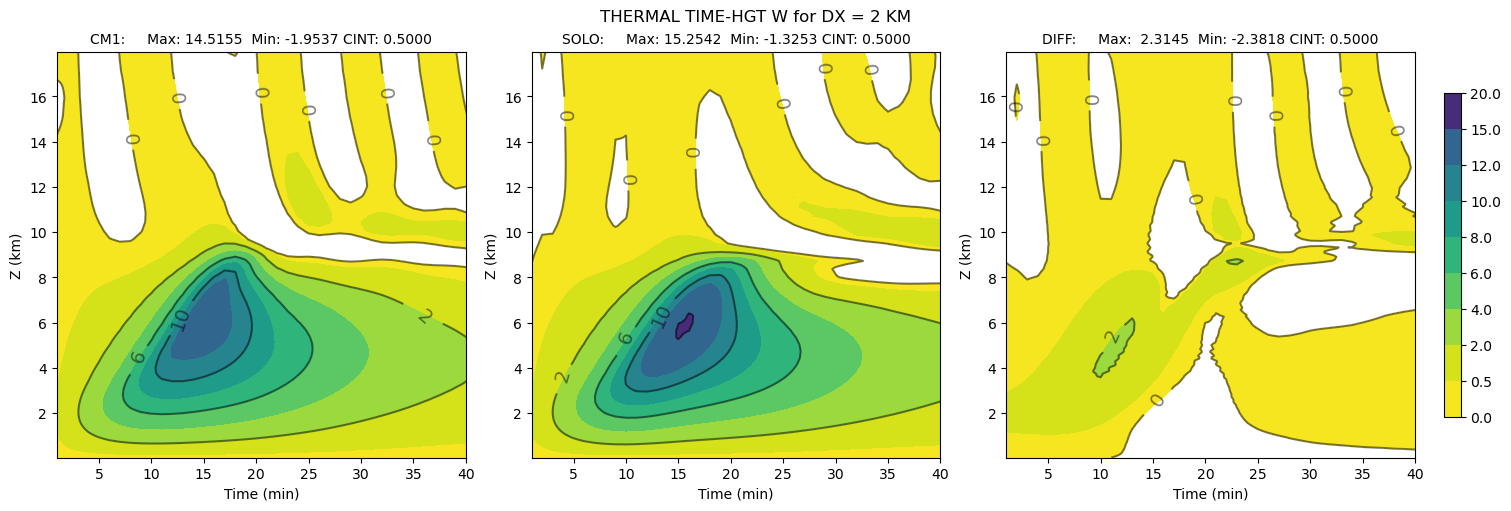

In [21]:
run = 1

time1 = solo[run]['min'][:]
time2 = cm1[run]['min'][:]

fields = []

iloc, jloc = 48, 48

solo_w = solo[run]['w'] [:, :, jloc, iloc].transpose()
solo_z = solo[run]['zc'][:, :, jloc, iloc].transpose()

cm1_w = cm1[run]['w'] [:, :, jloc, iloc].transpose()
cm1_z = cm1[run]['zc'][:, :, jloc, iloc].transpose()

diff_w = solo_w - cm1_w[:,0:60]

fields.append(container(cm1_w,  time2, cm1_z/1000.))
fields.append(container(solo_w, time1, solo_z/1000.))
fields.append(container(diff_w, time1, solo_z/1000.))

plot_contour_row(fields, levels=wclevs, suptitle='THERMAL TIME-HGT W for DX = 2 KM', ptitle=['CM1', 'SOLO','DIFF'], range=[1,40], xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r, cint=2.5);


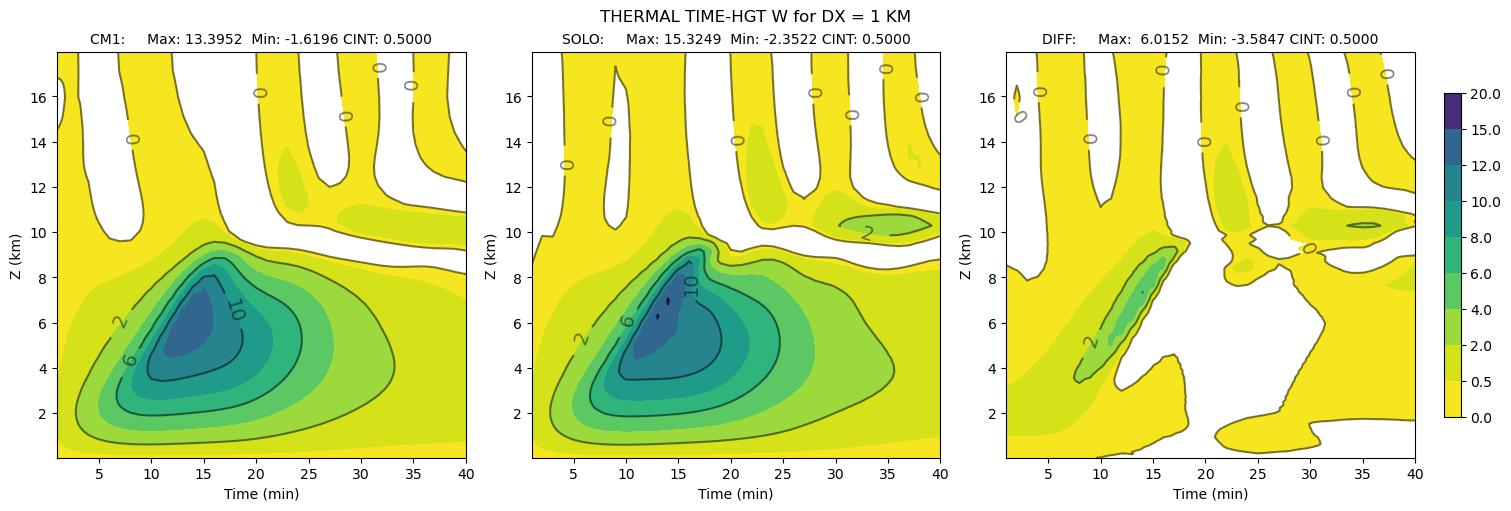

In [23]:
run = 2

time1 = solo[run]['min'][:]
time2 = cm1[run]['min'][:]

fields = []

iloc, jloc = 96, 96

solo_w = solo[run]['w'] [:, :, jloc, iloc].transpose()
solo_z = solo[run]['zc'][:, :, jloc, iloc].transpose()

cm1_w = cm1[run]['w'] [:, :, jloc, iloc].transpose()
cm1_z = cm1[run]['zc'][:, :, jloc, iloc].transpose()

diff_w = solo_w - cm1_w[:,0:60]

fields.append(container(cm1_w,  time2, cm1_z/1000.))
fields.append(container(solo_w, time1, solo_z/1000.))
fields.append(container(diff_w, time1, solo_z/1000.))

plot_contour_row(fields, levels=wclevs, suptitle='THERMAL TIME-HGT W for DX = 1 KM', ptitle=['CM1', 'SOLO', 'DIFF'], range=[1,40], xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r, cint=2.5);


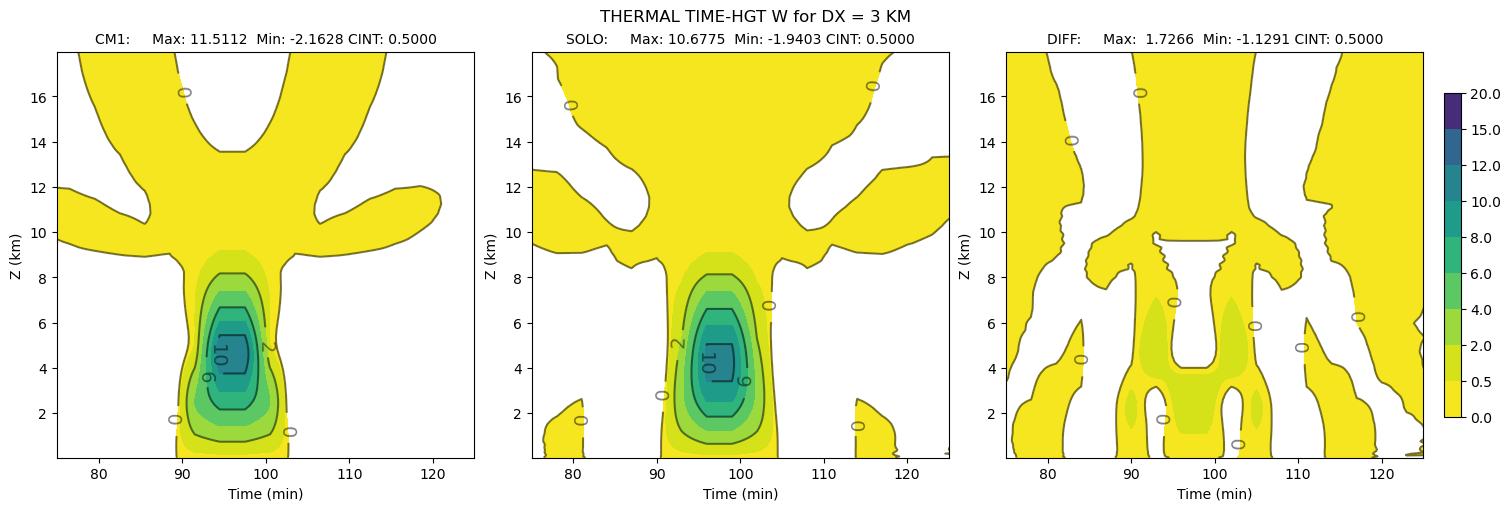

In [24]:
run = 0

time = 14

solo_time = solo[run]['min'][time]
cm1_time  = cm1[run]['min'][time+1]

fields = []

iloc, jloc = 32, 32

solo_w = solo[run]['w'] [time, :, :, iloc].transpose()
solo_x = np.broadcast_to(solo[run]['xc'][:, np.newaxis], solo_w.shape) / 1000.
solo_z = solo[run]['zc'][time, :, :, iloc].transpose()

cm1_w  = cm1[run]['w'] [time, :, :, iloc].transpose()
cm1_x  = np.broadcast_to(cm1[run]['xc'][:, np.newaxis], cm1_w.shape) / 1000.

cm1_z  = cm1[run]['zc'][time, :, :, iloc].transpose()

diff_w = solo_w - cm1_w[0:63,:]

fields.append(container(cm1_w,  cm1_x, cm1_z/1000.))
fields.append(container(solo_w, solo_x, solo_z/1000.))
fields.append(container(diff_w, solo_x, solo_z/1000.))

plot_contour_row(fields, levels=wclevs, suptitle='THERMAL TIME-HGT W for DX = 3 KM', ptitle=['CM1', 'SOLO', 'DIFF'], xlabel='Time (min)', range=[75.,125.],ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r, cint=2.5);


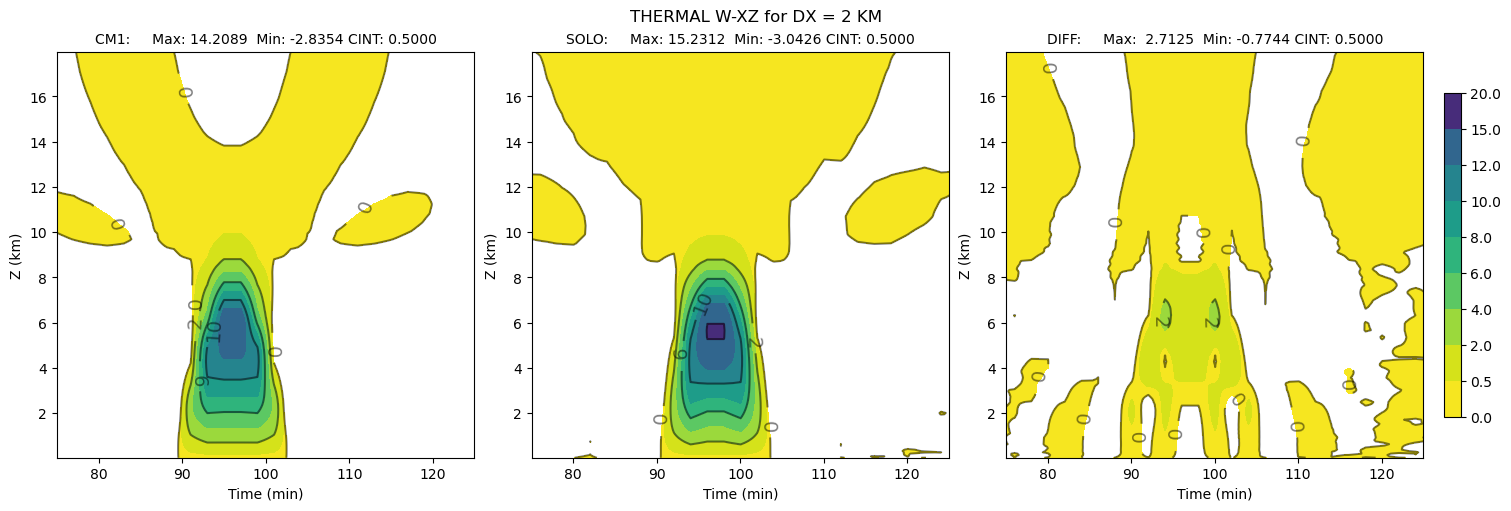

In [26]:
run = 1

time = 14

solo_time = solo[run]['min'][time]
cm1_time  = cm1[run]['min'][time+1]

fields = []

iloc, jloc = 48, 48

solo_w = solo[run]['w'] [time, :, :, iloc].transpose()
solo_x = np.broadcast_to(solo[run]['xc'][:, np.newaxis], solo_w.shape) / 1000. * 0.667
solo_z = solo[run]['zc'][time, :, :, iloc].transpose()

cm1_w  = cm1[run]['w'] [time, :, :, iloc].transpose()
cm1_x  = np.broadcast_to(cm1[run]['xc'][:, np.newaxis], cm1_w.shape) / 1000.

cm1_z  = cm1[run]['zc'][time, :, :, iloc].transpose()

diff_w = solo_w - cm1_w[0:95,:]

fields.append(container(cm1_w,  cm1_x, cm1_z/1000.))
fields.append(container(solo_w, solo_x, solo_z/1000.))
fields.append(container(diff_w, solo_x, solo_z/1000.))

plot_contour_row(fields, levels=wclevs, suptitle='THERMAL W-XZ for DX = 2 KM', ptitle=['CM1', 'SOLO','DIFF'], range=[75.,125.], xlabel='Time (min)',ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r, cint=2.5);


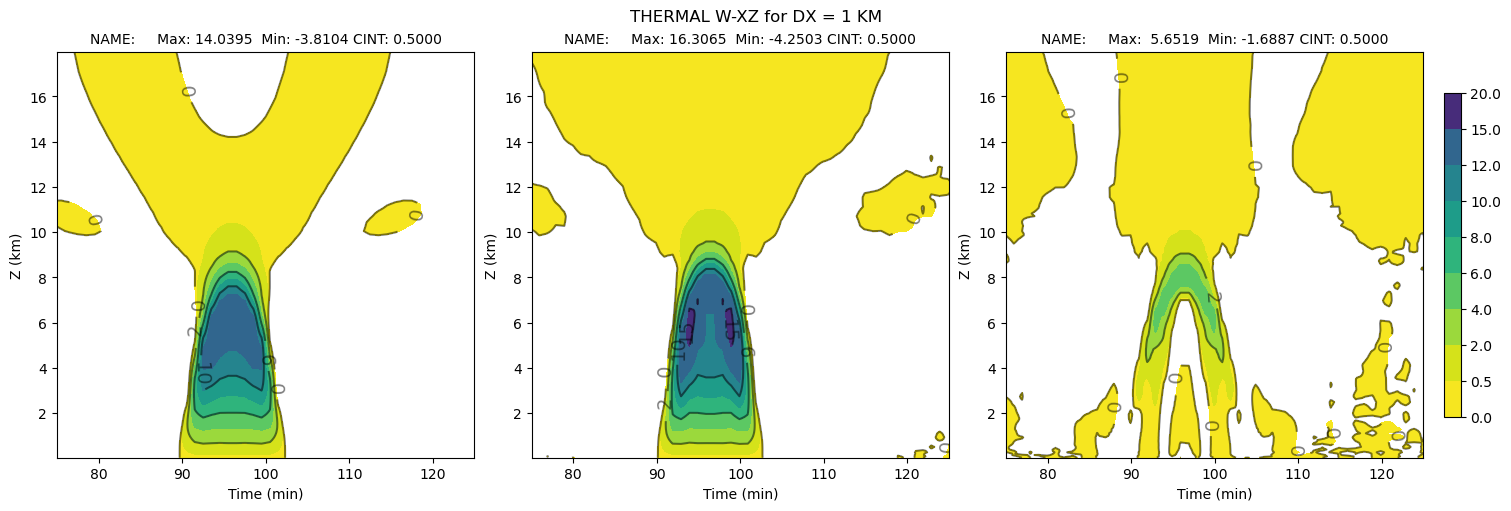

In [28]:
run = 2

time = 14

solo_time = solo[run]['min'][time]
cm1_time  = cm1[run]['min'][time+1]

fields = []

iloc, jloc = 96, 96

solo_w = solo[run]['w'] [time, :, :, iloc].transpose()
solo_x = np.broadcast_to(solo[run]['xc'][:, np.newaxis], solo_w.shape) / 1000. * 0.333
solo_z = solo[run]['zc'][time, :, :, iloc].transpose()

cm1_w  = cm1[run]['w'] [time, :, :, iloc].transpose()
cm1_x  = np.broadcast_to(cm1[run]['xc'][:, np.newaxis], cm1_w.shape) / 1000.

cm1_z  = cm1[run]['zc'][time, :, :, iloc].transpose()

diff_w = solo_w - cm1_w[0:191,:]

fields.append(container(cm1_w,  cm1_x, cm1_z/1000.))
fields.append(container(solo_w, solo_x, solo_z/1000.))
fields.append(container(diff_w, solo_x, solo_z/1000.))
plot_contour_row(fields, levels=wclevs, suptitle='THERMAL W-XZ for DX = 1 KM', ptitle=['CM1', 'SOLO'], range=[75,125.], xlabel='Time (min)',ylabel='Z (km)', extra_levels=wclevs, cmap=plt.cm.viridis_r, cint=2.5);
